# <center> Transfer Learning on CIFAR-10 using MobileNet_v2</center>

#### Load required libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


2024-02-29 16:01:19.988503: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-29 16:01:20.015942: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 16:01:20.015974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 16:01:20.016718: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 16:01:20.021163: I tensorflow/core/platform/cpu_feature_guar

#### a) Download and read the Cifar-10 dataset

In [2]:
def load_data(preprocess=True):
    """
    This function loads the cifar-10 dataset and returns the train and test data

    Args:
        preprocess (boolean): Decides if basic pre-processing is to be done on the data. Default is True.

    Returns:
         train_X (numpy.ndarray): Array containing training images of shape (num_samples,img_height,img_width)
         train_y (numpy.ndarray): Array containing one-hot encoded training labels of shape (num_samples,num_classes)
         test_X (numpy.ndarray): Array containing testing images of shape (num_samples,img_height,img_width)
         test_y (numpy.ndarray): Array containing one-hot encoded testing labels of shape (num_samples,num_classes)
    """

    # download the dataset
    dataset = tf.keras.datasets.cifar10
    (train_X, train_y), (test_X, test_y) = dataset.load_data()

    # preprocess the data if preprocessing = True
    if preprocess:
        # scale the pixel values in the range [-1,1]. Using the preprocessing function provided by tensorflow for mobilenet_v2
        train_X = tf.keras.applications.mobilenet_v2.preprocess_input(train_X)
        test_X = tf.keras.applications.mobilenet_v2.preprocess_input(test_X)
        # convert labels to one-hot encoding
        train_y = tf.keras.utils.to_categorical(train_y)
        test_y = tf.keras.utils.to_categorical(test_y)
        
    return train_X, train_y, test_X, test_y


In [3]:
train_X, train_y, test_X, test_y = load_data()
print("Number of traing samples:",len(train_y))
print("Number of testing samples:",len(test_y))
print("Shape of the training data:",train_X.shape)
print("Shape of the testing data:",test_X.shape)

Number of traing samples: 50000
Number of testing samples: 10000
Shape of the training data: (50000, 32, 32, 3)
Shape of the testing data: (10000, 32, 32, 3)


#### b) Downloading MobileNetV2

In [4]:
# Loading the backbone from MobileNetV2 
backbone = tf.keras.applications.MobileNetV2(
    # The smallest image size that MobileNetV2 is trained on is 96x96. So the input size is 96x96x3
    input_shape=(96,96,3),
    # Remove the top (the classifier part) from the MobileNetV2 by selecting include_top=False
    include_top=False,
    # Loding the pre-trained weights from imagenet
    weights='imagenet'
    )

# Freezing the parameters from the backbone (i.e. not updating them during training)
backbone.trainable = False

2024-02-29 16:01:22.663066: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-02-29 16:01:22.663094: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: v-labs-ai-rimmon-bhosale
2024-02-29 16:01:22.663099: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: v-labs-ai-rimmon-bhosale
2024-02-29 16:01:22.663168: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 470.223.2
2024-02-29 16:01:22.663183: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 470.223.2
2024-02-29 16:01:22.663186: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 470.223.2


#### c) Defining the new model

In [5]:
# Defining the new model

model = tf.keras.Sequential()

# Adding the input layer to the model
model.add(tf.keras.layers.InputLayer(input_shape=(32,32,3)))

# Resize the input images from 32x32 to the MobileNetV2's input size 96x96
model.add(tf.keras.layers.experimental.preprocessing.Resizing(96,96))

# Using the pre-trained feature extraction backbone from MobileNetV2 
model.add(backbone)

# Flattening the output features from the last layer in the backbone into 1D array using Global Average Pooling
model.add(tf.keras.layers.GlobalAveragePooling2D())

# Adding additional Dense layers to the top of the model. I have used ReLU activation function as it is simple, light-weight yet effective.
# I am using DropOut to counter for overfitting during model training. 
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(32, activation='relu'))

# Defining the output layer with 10 nodes and Softmax activation function to get class probabilities
model.add(tf.keras.layers.Dense(10, activation='softmax'))

#### d) Compiling the model

In [6]:
# Compiling the model 
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
    )

# View the model's summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8

#### e) Training the model

In [7]:
# Callback is used here for EarlyStopping the training. 
# This helps us to stop training pre-maturely if the model is overfitting (as observed from the trends in the training and validation loss)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

# Training the model using model.fit() function in Tensorflow
H = model.fit(train_X, train_y, epochs=10,validation_split=0.2,batch_size=50,shuffle=True,callbacks=[callback])

Epoch 1/10
800/800 [==============================] - 72s 89ms/step - loss: 0.7714 - accuracy: 0.7494 - val_loss: 0.4518 - val_accuracy: 0.8511
Epoch 2/10
800/800 [==============================] - 69s 86ms/step - loss: 0.5125 - accuracy: 0.8343 - val_loss: 0.4215 - val_accuracy: 0.8571
Epoch 3/10
800/800 [==============================] - 69s 86ms/step - loss: 0.4561 - accuracy: 0.8494 - val_loss: 0.4088 - val_accuracy: 0.8615
Epoch 4/10
800/800 [==============================] - 68s 85ms/step - loss: 0.4230 - accuracy: 0.8607 - val_loss: 0.4127 - val_accuracy: 0.8615
Epoch 5/10
800/800 [==============================] - 68s 85ms/step - loss: 0.3918 - accuracy: 0.8697 - val_loss: 0.4040 - val_accuracy: 0.8648
Epoch 6/10
800/800 [==============================] - 69s 86ms/step - loss: 0.3710 - accuracy: 0.8769 - val_loss: 0.4053 - val_accuracy: 0.8641
Epoch 7/10
800/800 [==============================] - 70s 87ms/step - loss: 0.3434 - accuracy: 0.8834 - val_loss: 0.3947 - val_accuracy:

#### f) Plotting the performance on train and validation datasets during training 

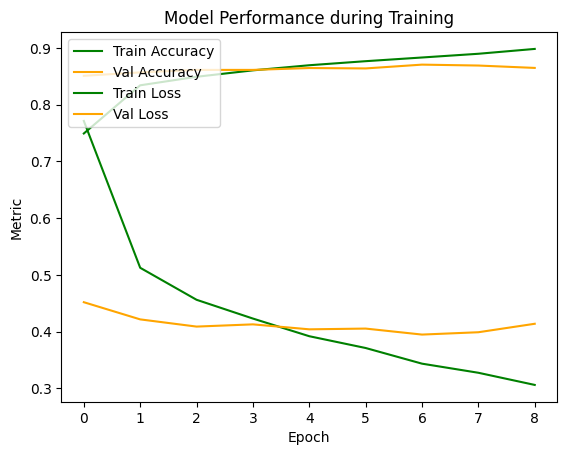

In [12]:
# Plot the training and validation performance over epochs
plt.plot(H.history['accuracy'],label='Train Accuracy',color='green')
plt.plot(H.history['val_accuracy'],label='Val Accuracy',color='orange')
plt.plot(H.history['loss'],label='Train Loss',color='green')
plt.plot(H.history['val_loss'],label='Val Loss',color='orange')
plt.title('Model Performance during Training')
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

#### g) Evaluating the performance of the model

In [11]:
# Evaluating the performance of the trained model on the entire train and test data
train_loss, train_acc = model.evaluate(train_X,  train_y,verbose=0)
test_loss, test_acc = model.evaluate(test_X,  test_y,verbose=0)

print('Train Accuracy:', train_acc)
print('Train Loss:', train_loss)
print('Test Accuracy:', test_acc)
print('Test Loss:', test_loss)

Train Accuracy: 0.9125400185585022
Train Loss: 0.25522077083587646
Test Accuracy: 0.8614000082015991
Test Loss: 0.4313564896583557


In [10]:
"""
Train Accuracy: 0.9080600142478943
Train Loss: 0.27264657616615295
Test Accuracy: 0.8619999885559082
Test Loss: 0.4132399559020996
"""

"""
Train Accuracy: 0.9015600085258484
Train Loss: 0.2912510633468628
Test Accuracy: 0.858299970626831
Test Loss: 0.42619237303733826
"""

"""
Train Accuracy: 0.9202200174331665
Train Loss: 0.24629132449626923
Test Accuracy: 0.8604999780654907
Test Loss: 0.42678597569465637
"""

"""
Train Accuracy: 0.9125400185585022
Train Loss: 0.25522077083587646
Test Accuracy: 0.8614000082015991
Test Loss: 0.4313564896583557
"""

'\nTrain Accuracy: 0.8914600014686584\nTrain Loss: 0.3196108341217041\nTest Accuracy: 0.852400004863739\nTest Loss: 0.4362577497959137\n'